# 1. Impor *Pustaka*

In [14]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=d38229a1fee015cc4ec491151ba157e320345ffee078fac434092dd396733798
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [15]:
# Impor pustaka yang diperlukan
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import pandas as pd

#2. Membuka Sesi Spark

In [16]:
# Membuka sesi Spark dan beri nama sesi
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Temperature_Prediction').getOrCreate()


#3. Memuat Data


In [17]:
!wget https://raw.githubusercontent.com/azar-s91/dataset/master/weatherHistory.csv

--2024-10-18 06:25:42--  https://raw.githubusercontent.com/azar-s91/dataset/master/weatherHistory.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5769361 (5.5M) [text/plain]
Saving to: ‘weatherHistory.csv.2’

weatherHistory.csv. 100%[===================>]   5.50M  --.-KB/s    in 0.09s   

2024-10-18 06:25:42 (58.5 MB/s) - ‘weatherHistory.csv.2’ saved [5769361/5769361]



In [19]:
# Memuat data ke dalam DataFrame Spark
df = spark.read.csv("weatherHistory.csv", header=True, inferSchema=True)

In [20]:
# Tampilkan skema dan beberapa baris data
df.printSchema()
df.show(5)


root
 |-- DateTime: string (nullable = true)
 |-- Temperature (C): double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Wind Speed (km/h): double (nullable = true)
 |-- Pressure (millibars): double (nullable = true)
 |-- Summary: string (nullable = true)

+---------------+---------------+--------+-----------------+--------------------+-------------+
|       DateTime|Temperature (C)|Humidity|Wind Speed (km/h)|Pressure (millibars)|      Summary|
+---------------+---------------+--------+-----------------+--------------------+-------------+
|4/1/06 12:00 AM|    9.472222222|    0.89|          14.1197|             1015.13|Partly Cloudy|
| 4/1/06 1:00 AM|    9.355555556|    0.86|          14.2646|             1015.63|Partly Cloudy|
| 4/1/06 2:00 AM|    9.377777778|    0.89|           3.9284|             1015.94|Mostly Cloudy|
| 4/1/06 3:00 AM|    8.288888889|    0.83|          14.1036|                NULL|Partly Cloudy|
| 4/1/06 4:00 AM|    8.755555556|    0.83|          11.

#4. Pembersihan Data:

In [23]:
from pyspark.sql.functions import col, mean, when

# Hitung rata-rata untuk kolom yang relevan
mean_values = df.select(
    mean("Temperature (C)").alias("mean_temp"),
    mean("Humidity").alias("mean_humidity"),
    mean("Wind Speed (km/h)").alias("mean_wind_speed"),
    mean("Pressure (millibars)").alias("mean_pressure")
).first()



In [24]:
# Ambil rata-rata dari hasil perhitungan
mean_temp = mean_values[0]
mean_humidity = mean_values[1]
mean_wind_speed = mean_values[2]
mean_pressure = mean_values[3]

In [25]:
# Ganti nilai null dengan rata-rata
df_cleaned = df.na.fill({
    "Temperature (C)": mean_temp,
    "Humidity": mean_humidity,
    "Wind Speed (km/h)": mean_wind_speed,
    "Pressure (millibars)": mean_pressure
})


In [27]:
# Ganti nilai 0 dengan rata-rat
df_cleaned = df_cleaned.withColumn("Temperature (C)", when(col("Temperature (C)") == 0, mean_temp).otherwise(col("Temperature (C)"))) \
    .withColumn("Humidity", when(col("Humidity") == 0, mean_humidity).otherwise(col("Humidity"))) \
    .withColumn("Wind Speed (km/h)", when(col("Wind Speed (km/h)") == 0, mean_wind_speed).otherwise(col("Wind Speed (km/h)"))) \
    .withColumn("Pressure (millibars)", when(col("Pressure (millibars)") == 0, mean_pressure).otherwise(col("Pressure (millibars)")))

In [28]:
# Tampilkan data yang sudah dibersihkan
df_cleaned.show(5)

+---------------+---------------+--------+-----------------+--------------------+-------------+
|       DateTime|Temperature (C)|Humidity|Wind Speed (km/h)|Pressure (millibars)|      Summary|
+---------------+---------------+--------+-----------------+--------------------+-------------+
|4/1/06 12:00 AM|    9.472222222|    0.89|          14.1197|             1015.13|Partly Cloudy|
| 4/1/06 1:00 AM|    9.355555556|    0.86|          14.2646|             1015.63|Partly Cloudy|
| 4/1/06 2:00 AM|    9.377777778|    0.89|           3.9284|             1015.94|Mostly Cloudy|
| 4/1/06 3:00 AM|    8.288888889|    0.83|          14.1036|  1003.2349854841107|Partly Cloudy|
| 4/1/06 4:00 AM|    8.755555556|    0.83|          11.0446|             1016.51|Mostly Cloudy|
+---------------+---------------+--------+-----------------+--------------------+-------------+
only showing top 5 rows



#5. Perhitungan Korelasi:

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import corr

In [30]:
# Mengonversi DataFrame Spark ke Pandas untuk analisis lebih lanjut
pdf = df_cleaned.toPandas()

In [32]:
# Menghapus kolom non-numerik
pdf = pdf.drop(columns=["DateTime", "Summary"])

In [33]:
# Menghitung nilai korelasi
correlation_matrix = pdf.corr()

In [34]:
# Menampilkan nilai korelasi antara suhu dan variabel lainnya
print(correlation_matrix["Temperature (C)"])

Temperature (C)         1.000000
Humidity               -0.635028
Wind Speed (km/h)       0.007357
Pressure (millibars)   -0.299465
Name: Temperature (C), dtype: float64


In [35]:
# Memilih variabel dengan korelasi kuat (minimal 0.5)
strong_corr_vars = correlation_matrix.index[abs(correlation_matrix["Temperature (C)"]) >= 0.5].tolist()
print("Variabel dengan korelasi kuat:", strong_corr_vars)

Variabel dengan korelasi kuat: ['Temperature (C)', 'Humidity']


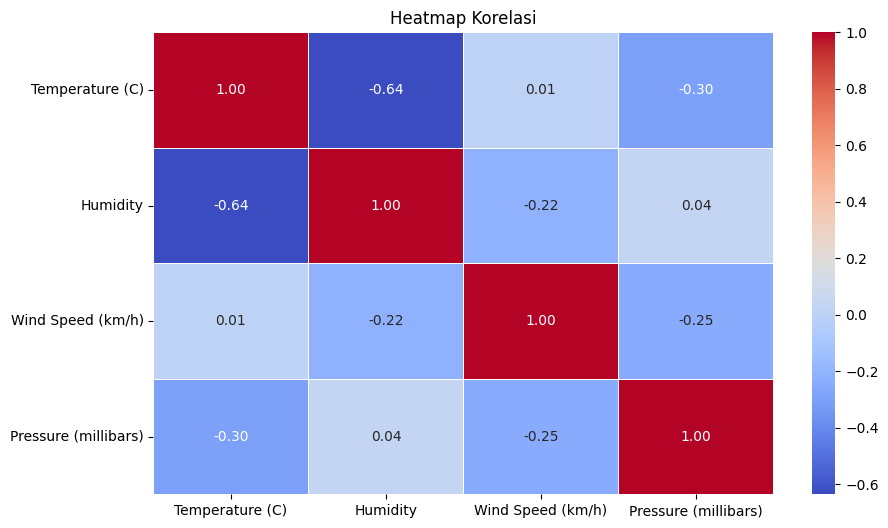

In [36]:
# Visualisasi heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi")
plt.show()

#6. Pembuatan Vektor Fitur:

In [37]:
from pyspark.ml.feature import VectorAssembler

# Tentukan kolom fitur yang ingin digunakan (contoh: Humidity, Wind Speed, Pressure)
feature_columns = ["Humidity", "Wind Speed (km/h)", "Pressure (millibars)"]

In [38]:
# Buat objek VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [39]:
# Terapkan VectorAssembler ke DataFrame
df_features = assembler.transform(df_cleaned)

In [40]:
# Tampilkan skema DataFrame yang baru
df_features.printSchema()

root
 |-- DateTime: string (nullable = true)
 |-- Temperature (C): double (nullable = false)
 |-- Humidity: double (nullable = false)
 |-- Wind Speed (km/h): double (nullable = false)
 |-- Pressure (millibars): double (nullable = false)
 |-- Summary: string (nullable = true)
 |-- features: vector (nullable = true)



In [41]:
# Tampilkan beberapa baris data untuk memeriksa kolom 'features'
df_features.select("features").show(5)

+--------------------+
|            features|
+--------------------+
|[0.89,14.1197,101...|
|[0.86,14.2646,101...|
|[0.89,3.9284,1015...|
|[0.83,14.1036,100...|
|[0.83,11.0446,101...|
+--------------------+
only showing top 5 rows



#7. Pembagian Data Latih-Uji:

In [42]:
# Pembagian data latih (80%) dan data uji (20%)
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

In [43]:
# Menampilkan jumlah baris di masing-masing dataset
print("Jumlah baris di dataset latih:", train_data.count())
print("Jumlah baris di dataset uji:", test_data.count())

Jumlah baris di dataset latih: 77077
Jumlah baris di dataset uji: 19376


#8. Pelatihan Model:

In [44]:
from pyspark.ml.regression import LinearRegression

# Inisialisasi model regresi linier
lr = LinearRegression(featuresCol="features", labelCol="Temperature (C)")


In [45]:
# Latih model dengan dataset latih
lr_model = lr.fit(train_data)

In [46]:
# Tampilkan koefisien dan intersep model
print("Koefisien:", lr_model.coefficients)
print("Intersep:", lr_model.intercept)

Koefisien: [-32.63327415058465,-0.3082155810974032,-0.3969265912040569]
Intersep: 442.87898912177127


#9. Evaluasi Model:


In [47]:
from pyspark.ml.evaluation import RegressionEvaluator

# Buat prediksi pada data uji
predictions = lr_model.transform(test_data)

In [48]:
# Tampilkan beberapa prediksi
predictions.select("Temperature (C)", "prediction").show(5)


+---------------+-----------------+
|Temperature (C)|       prediction|
+---------------+-----------------+
|    3.822222222|7.117631342493212|
|    1.161111111|6.682686918722368|
|    1.666666667|6.651351375396018|
|    5.972222222|9.508131066833528|
|    5.472222222|7.245668016485979|
+---------------+-----------------+
only showing top 5 rows



In [49]:
# Inisialisasi evaluator untuk regresi
evaluator = RegressionEvaluator(labelCol="Temperature (C)", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

In [50]:
# Menghitung MSE
evaluator.setMetricName("mse")
mse = evaluator.evaluate(predictions)

In [51]:
# Tampilkan hasil evaluasi
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Squared Error (MSE):", mse)

Root Mean Squared Error (RMSE): 6.612595270963468
Mean Squared Error (MSE): 43.72641621756842


#10. Visualisasi Hasil:

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
# Ambil kolom yang diperlukan dari DataFrame prediksi
results = predictions.select("Temperature (C)", "prediction").toPandas()


In [54]:
# Hitung residual
results['residual'] = results['Temperature (C)'] - results['prediction']

In [55]:
# Visualisasi Suhu Aktual vs. Suhu Prediksi
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

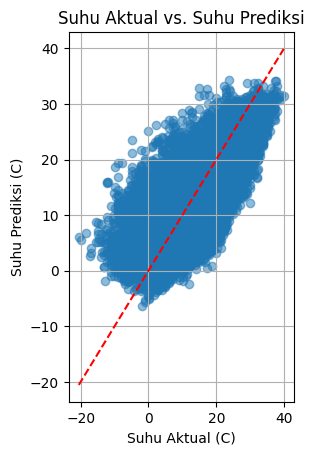

In [56]:
# Suhu Aktual vs. Suhu Prediksi
plt.subplot(1, 2, 1)
plt.scatter(results['Temperature (C)'], results['prediction'], alpha=0.5)
plt.plot([results['Temperature (C)'].min(), results['Temperature (C)'].max()],
         [results['Temperature (C)'].min(), results['Temperature (C)'].max()],
         color='red', linestyle='--')
plt.title("Suhu Aktual vs. Suhu Prediksi")
plt.xlabel("Suhu Aktual (C)")
plt.ylabel("Suhu Prediksi (C)")
plt.grid()


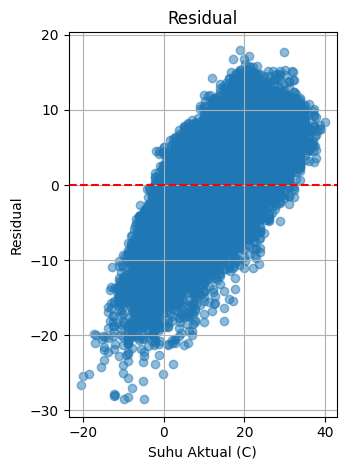

In [57]:
# Visualisasi Residual
plt.subplot(1, 2, 2)
plt.scatter(results['Temperature (C)'], results['residual'], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual")
plt.xlabel("Suhu Aktual (C)")
plt.ylabel("Residual")
plt.grid()

plt.tight_layout()
plt.show()